# VAE: Variational Autoencoder

## VAE

Let's briefly see how VAE works.

### Introduction

Generator $P(X|z)$: given $z$, it generates $\hat{X}$. $z \mapsto \hat{X}$.

We couple this generator with an encoder, which does the opposite: given the input instance $X$, it builds the latent encoding of $X$ (i.e. $z$). $X \mapsto z$.

Basically, we structure the model as an Autoencoder.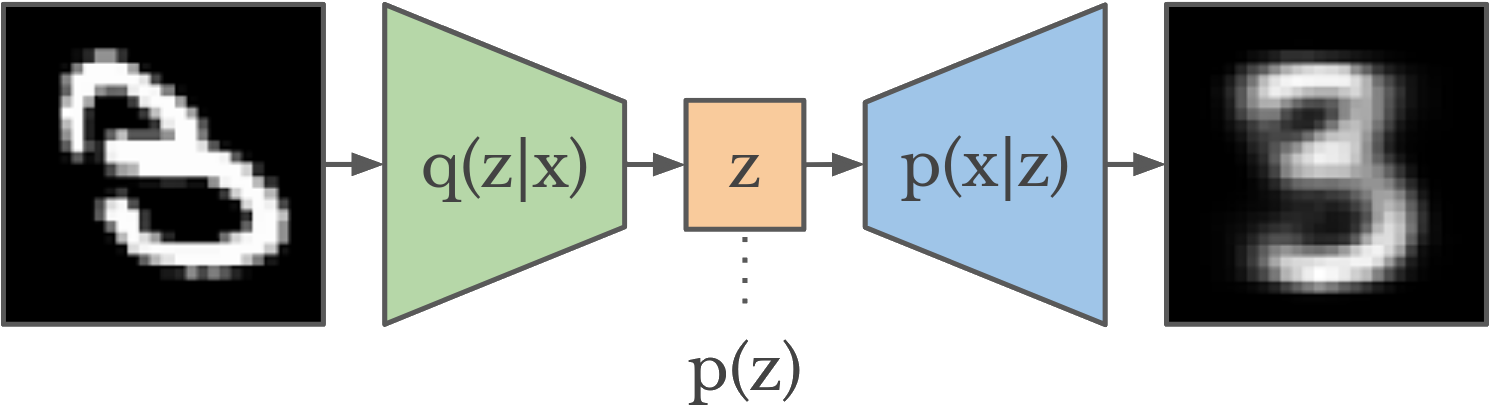

- The decoder is the generator: $P(X|z)$.
- THe encoder is about $Q(z|X)$, which is an approximation of the true distribution $P(z|X)$.
- THe Autoencoder encoding is the latent variable $z$, with known prior distribution $P(z)$ (i.e. multivariate normal gaussian).

Like the classic AE, also the VAE can be either fully Dense or Convolutional.

**Difference normal AE - VAE**

Suppose that we have an already trained generic AE (i.e. Autoencoder). Can we use the decoder as generator? NO!!! Because we don't know the prior distribution of $z$. We don't know $P(z)$. So, we don't know how to sample from $P(z)$.

If we generate a random $z$, it can be outside the latent space $P(z)$: in such case, we would generate an instance $\hat{X}$ which is not sensible, which is not valid.

Instead, if we have a VAE, we can use the decoder as generator. Because we know how to sample from $P(z)$, since we know $P(z)$.

**Loss function: idea**

The loss function has to measure the distance between the input data $X$ and the corresponding generated instance $\hat{X}$ (log-likelihood).

But that's not all. We have said that the prior distribution $P(z)$ is known (multivariate gaussian).

However, since $z$ is produced by an encoder, we have to force that. We have to force that the distribution of $z$ is the desired one (multivariate gaussian).

We do that by adding a specific component into the loss function, which measures the distance between the current distribution of $z$ and the desired one.

### Insight: how $z$ is actually generated

Since now, we have said that the encoder generated $z$ given $X$. This can be seen as generating the mean of the distribution $Q(z|X)$: $\mu(z|X)$. So, $z$ is generated as $\mu(z|X)$.

Actually, $z$ is generated in a more robust way. 

In addition to the mean $\mu(z|X)$, the encoder produces also the std $\sigma(z|X)$. So, the encoder has two outputs: $\mu(z|X)$ and $\sigma(z|X)$.

Given these values, we generate a sample $z$ from $Q(z|X)$. We sample around the mean $\mu(z|X)$ using the std $\sigma(z|X)$. More specifically, we sample from the normal distribution with mean $\mu(z|X)$ and std $\sigma(z|X)$: we sample from $N(\mu(z|X),\sigma(z|X))$.

In practice, $z$ is computed as $\mu(z|X)+\sigma(z|X)*\epsilon$, where $\epsilon$ is sampled from the normal distribution $N(0,1)$.

It is important to remark that we are talking about multivariate distributions: $\mu(z|X)$, $\sigma(z|X)$ and $\epsilon$ are vectors of values.

The following is the overall picture. 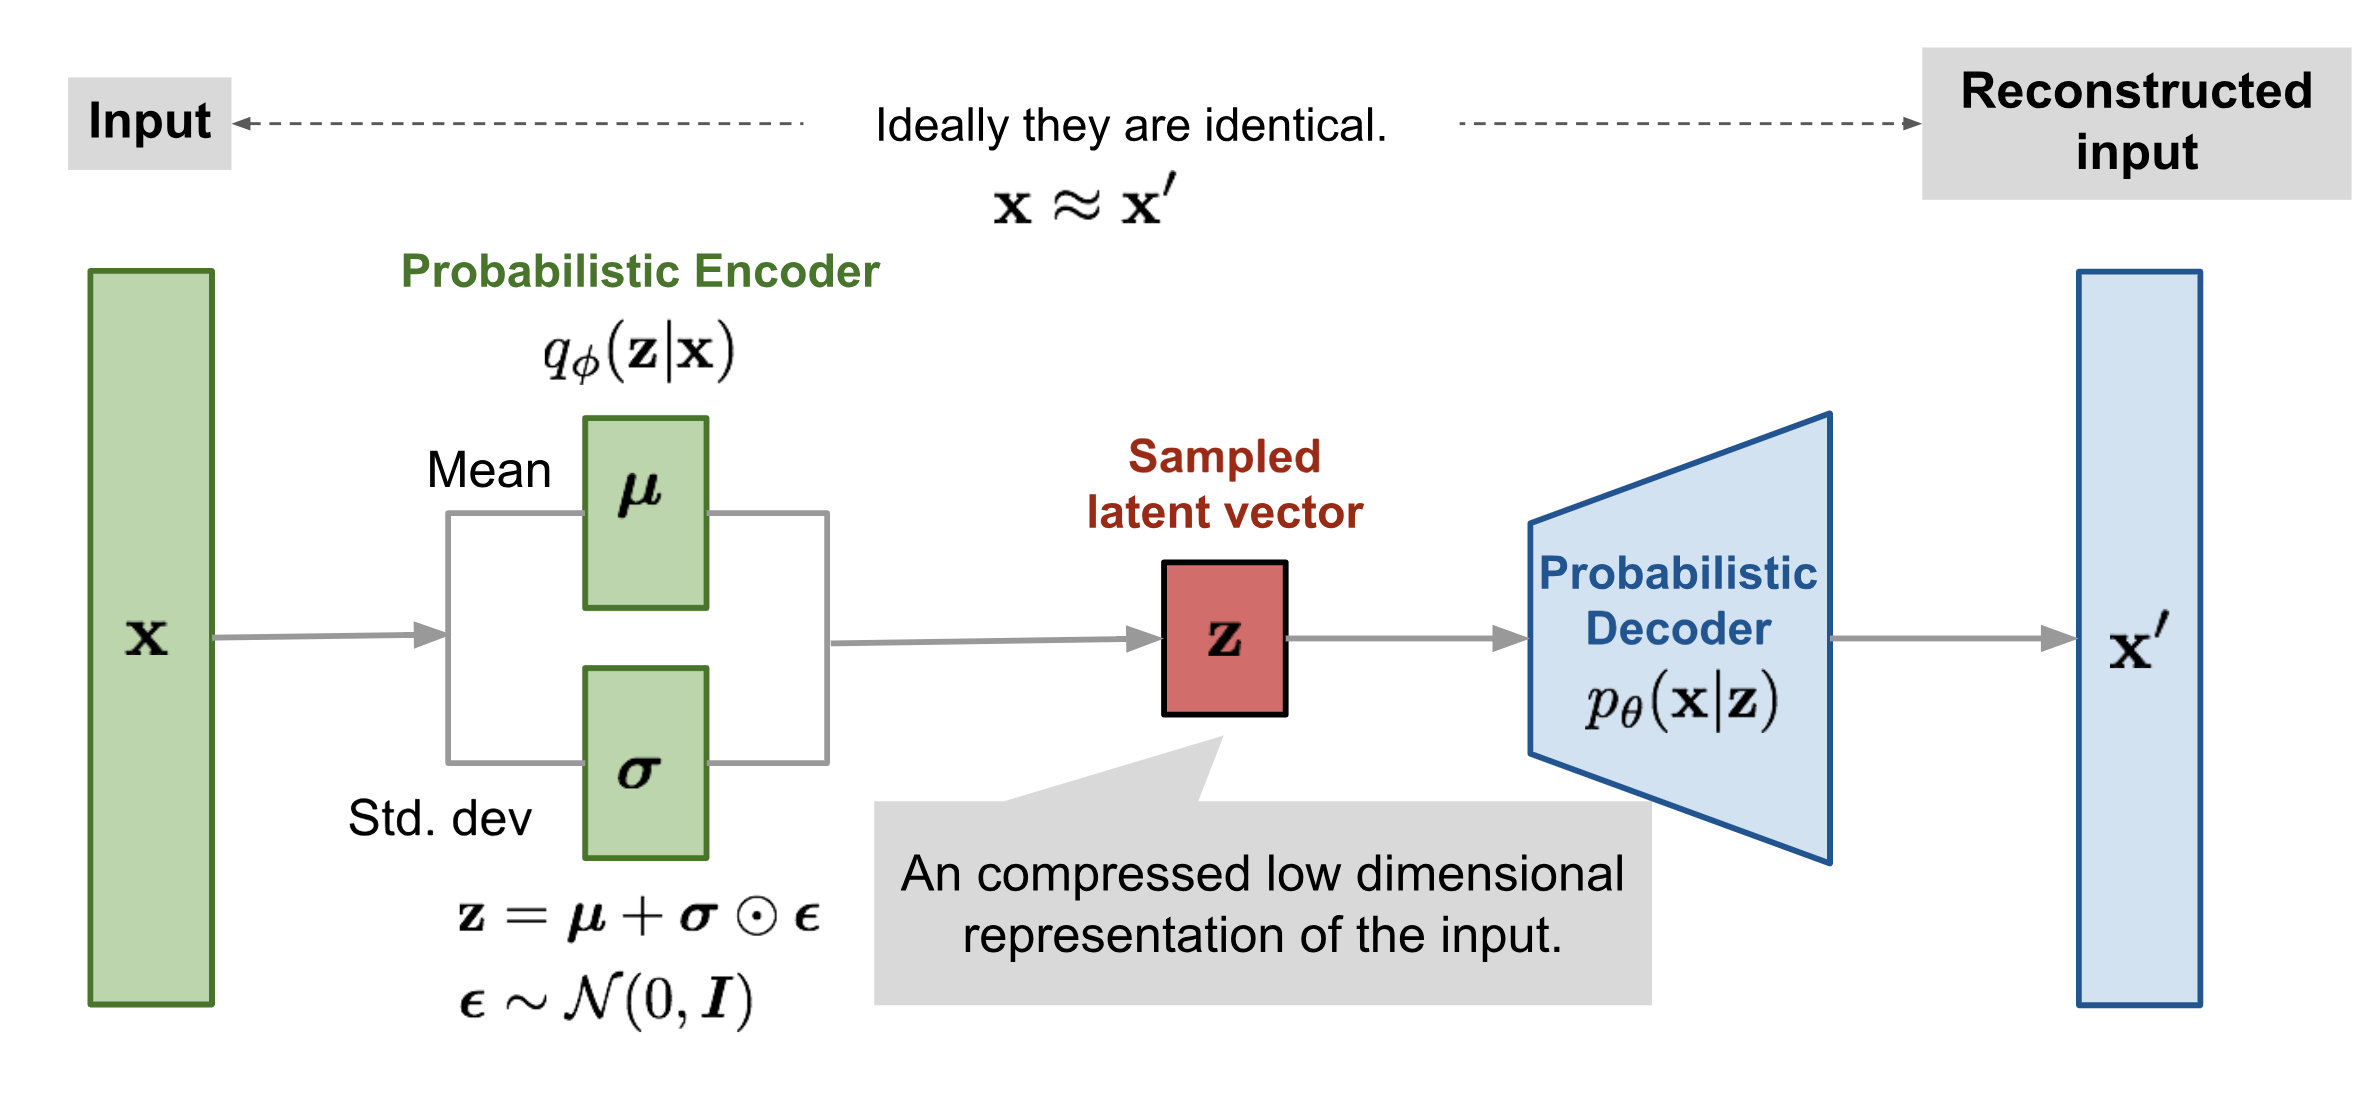

### Insight: loss function

Two comonents.
1. **Reconstruction loss**. We measure the distance between the real image $X$ and the generated one $\hat{X}$. $||X-\hat{X}||^2$.
2. **Kullback Leibler Divergence KL**. We measure distance between the distribution of $z$ (i.e. $P(z)$) and the desired distribution (i.e. $N(0,1)$. Actually, we measure the distance between each distribution $Q(z|X)$ (for each input image $X$) and the desired distribution $N(0,1)$ (it can be proved that in this way we force the overall $P(z)$ to $N(0,1)$). $KL(N(0,1), Q(z|X)) = 1/2 * (\sigma(z|X)^2+\mu(z|X)-1+ln(\sigma(z|X))$ 

## VAE MNIST dataset

Let's implement the VAE model on the MNISt dataset. In particular, we implement a fully Dense VAE.

In [1]:
# Utilities
import numpy as np
import matplotlib.pyplot as plt

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

# Import keras dataset Mnist
from tensorflow.keras.datasets import mnist

### Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Normalization

In [3]:
x_train = x_train / 255.0
x_test = x_test / 255.0

Flattening (we use only Dense layers)

In [4]:
# Flattening each image in the training set
x_train = np.reshape(x_train, (60000,28*28)) 

# Flattening each image in the test set
x_test = np.reshape(x_test, (10000,28*28))

### Latent dimension

We decide since now the dimensionality of $z$: $16$.

In [5]:
latent_dim = 16

### Sampling function

We define the sampling function. Given the mean $\mu(z|X)$ and std $\sigma(z|X)$ produced by the encoder, it samples a latent encoding $z$, which is the variable to give to the generator.

$z$ is computed as $\mu(z|X)+\sigma(z|X)*\epsilon$, where $\epsilon$ is sampled from the normal distribution $N(0,1)$.

It is important to remark that we are talking about multivariate distributions: $z$, $\mu(z|X)$, $\sigma(z|X)$ and $\epsilon$ are vectors of values. They are all vectors of dimensions $16$.

In [6]:
def sampling(inputs):
    z_mean, z_log_var = inputs
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

### Encoder

The encoder takes in input an image: $28*28=784$ values. Flat input.

We produce two outputs: the mean $\mu(z|X)$ and the std $\sigma(z|X)$. Both of them are vectors of dimensions $16$ (i.e. `latent_dim`).

Actually, the encoder produces the log-variance $log(\sigma(z|X)^2)$ instead of the std $\sigma(z|X)$. 

The encoder simply consists of some Dense layers.

In [7]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import Model

In [86]:
# Input image x
xin = Input(shape=(784,))

# Some Dense layers
x = Dense(128, activation='swish')(xin)
x = Dense(32, activation='swish')(x)

# One Dense layer for producing the mean and one Dense layer for producing the log-variance
z_mean = Dense(units=latent_dim)(x)
z_log_var = Dense(units=latent_dim)(x)

# Model
encoder = Model(inputs=xin, outputs=[z_mean, z_log_var], name='Encoder')

In [9]:
encoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          100480      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 32)           4128        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 16)           528         ['dense_1[0][0]']                
                                                                                            

### Decoder

It takes as input a latent encoding $z$: dimension $16$. It generates a reconstructed image $\hat{X}$: dimension $784$. 

The last layer of the decoder uses the **sigmoid** activation function, since we want values between $0$ and $1$.

Very simmetric with respect to the encoder.

The decoder is our generator.

In [10]:
# Input: latent encoding z
zin = Input(shape=(latent_dim,))

# Dense layers
z = Dense(units=32, activation='swish')(zin)
z = Dense(units=128, activation='swish')(z)

# Dense layers for generating the image
x_hat = Dense(units=784, activation='sigmoid')(z)

# Model
decoder = Model(inputs=zin, outputs=x_hat, name='Decoder')

In [11]:
decoder.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 128)               4224      
                                                                 
 dense_6 (Dense)             (None, 784)               101136    
                                                                 
Total params: 105,904
Trainable params: 105,904
Non-trainable params: 0
_________________________________________________________________


### Sampling layer

Between the encoder and the decoder, we have to put the sampling operation: fiven the mean $\mu(z|X)$ and the log-variance $log(\sigma(z|X)^2)$, it generates a sample $z$.

This is implemented using a layer. In particular, in keras we can use the `lambda` layer for building a layer starting from a function. (In our case, the `sampling` function).

In [12]:
from tensorflow.keras.layers import Lambda

### VAE model

Finally, let's define the VAE model.
1. We use the encoder as a single layer.
2. We define the sampling layer.
3. We use the decoder as a single layer.

In [13]:
# Input: image x
x = Input(shape=(784,))

# Encoder: it returns the mean and the variance
z_mean, z_log_var = encoder(x)

# Sampling z
z = Lambda(function=sampling, output_shape=(latent_dim,), name='Sampling')([z_mean, z_log_var])

# Decoder: it generates the image x_hat
x_hat = decoder(z)

# Model
vae = Model(inputs=x, outputs=x_hat, name='VAE')

In [14]:
vae.summary()

Model: "VAE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 Encoder (Functional)           [(None, 16),         105664      ['input_3[0][0]']                
                                 (None, 16)]                                                      
                                                                                                  
 Sampling (Lambda)              (None, 16)           0           ['Encoder[0][0]',                
                                                                  'Encoder[0][1]']                
                                                                                                

### Loss function

Sum between two components: reconstruction error and KL divergence.

In [49]:
from tensorflow.keras import metrics

In [68]:
# We define our loss function
rec_loss = 784 * metrics.binary_crossentropy(x, x_hat)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(rec_loss + kl_loss)

In [ ]:
# We add the loss into our model
vae.add_loss(vae_loss)

In [64]:
# TO DELETE
def loss(x, x_hat):
    print(x.shape, x_hat.shape)
    reconstruction_err = 784 * metrics.binary_crossentropy(x, x_hat)
    print(reconstruction_err.shape)
    kl_divergence = -0.5 * tf.math.reduce_sum(1 + z_log_var, axis=-1) #-tf.math.square(z_mean), axis=-1) #- tf.math.exp(z_log_var), axis=-1)
    print(kl_divergence.shape)
    
    return tf.math.reduce_mean(reconstruction_err + kl_divergence, axis=-1)

In [43]:
reconstruction_err = 784 * metrics.binary_crossentropy(x, x_hat)

kl_divergence = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

loss = K.mean(reconstruction_err + kl_divergence)

### Compile

In [65]:
vae.compile(optimizer='adam')

### Training

In [18]:
batch_size = 100
epochs = 50

In [70]:
vae.fit(x_train, None, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/50
600/600 [==============================] - 3s 3ms/step - loss: 161.3051 - val_loss: 130.4654
Epoch 2/50
600/600 [==============================] - 2s 4ms/step - loss: 127.4266 - val_loss: 123.0865
Epoch 3/50
600/600 [==============================] - 2s 3ms/step - loss: 122.5976 - val_loss: 119.9925
Epoch 4/50
600/600 [==============================] - 2s 3ms/step - loss: 119.6585 - val_loss: 117.1553
Epoch 5/50
600/600 [==============================] - 2s 3ms/step - loss: 117.3305 - val_loss: 115.2882
Epoch 6/50
600/600 [==============================] - 2s 3ms/step - loss: 115.4961 - val_loss: 114.2643
Epoch 7/50
600/600 [==============================] - 2s 4ms/step - loss: 114.2047 - val_loss: 112.5973
Epoch 8/50
600/600 [==============================] - 2s 4ms/step - loss: 113.1602 - val_loss: 112.0301
Epoch 9/50
600/600 [==============================] - 2s 3ms/step - loss: 112.2937 - val_loss: 111.1729
Epoch 10/50
600/600 [==============================] - 2s 3ms/st

In [54]:
# TO DELETE
x_train.shape

(60000, 784)

In [66]:
vae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, x_test))

Epoch 1/50
(100, 784) (100, 784)
(100,)
(None,)


TypeError: in user code:

    File "C:\Users\pitti\anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\pitti\anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\pitti\anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\pitti\anaconda3\lib\site-packages\keras\engine\training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\pitti\anaconda3\lib\site-packages\keras\engine\training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "C:\Users\pitti\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 239, in __call__
        self._loss_metric.update_state(
    File "C:\Users\pitti\anaconda3\lib\site-packages\keras\utils\metrics_utils.py", line 70, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "C:\Users\pitti\anaconda3\lib\site-packages\keras\metrics.py", line 178, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "C:\Users\pitti\anaconda3\lib\site-packages\keras\metrics.py", line 455, in update_state  **
        sample_weight = tf.__internal__.ops.broadcast_weights(
    File "C:\Users\pitti\anaconda3\lib\site-packages\numpy\core\_asarray.py", line 102, in asarray
        return array(a, dtype, copy=False, order=order)
    File "C:\Users\pitti\anaconda3\lib\site-packages\keras\engine\keras_tensor.py", line 254, in __array__
        raise TypeError(

    TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'tf.cast_54'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.


### Generating MNIST images

Now we want to generate some MNIST images. How to do that?

The decoder is our generator. Given a latent encoding $z$, it generates an image $\hat{X}$ compliant with our dataset: so, a MNIST image.

The latent encoding $z$ is sampled from the latent space $N(0,1)$.

We want to generate $n$ MNIST images.

In [83]:
n = 10

In [84]:
# Sample of n latent vectors 'z'. Each of them is a vector with 'latent_dim' values.
z_sample = np.random.normal(size=(n, latent_dim))
print('z_sample shape:', z_sample.shape)

# n generated MNISt images
generated_images = decoder.predict(z_sample)
print('generated_images shape:', generated_images.shape)

z_sample shape: (10, 16)
generated_images shape: (10, 784)


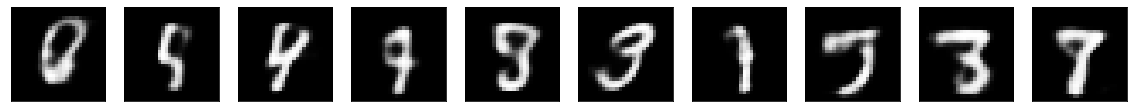

In [81]:
plt.figure(figsize=(2*n, 2))
for i in range(n):
  ax = plt.subplot(1, n, i + 1)
  plt.imshow(generated_images[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

Training again other $50$ epochs

In [82]:
vae.fit(x_train, None, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/50
600/600 [==============================] - 2s 3ms/step - loss: 104.2643 - val_loss: 103.9662
Epoch 2/50
600/600 [==============================] - 2s 3ms/step - loss: 104.2084 - val_loss: 104.4129
Epoch 3/50
600/600 [==============================] - 2s 4ms/step - loss: 104.1443 - val_loss: 104.1659
Epoch 4/50
600/600 [==============================] - 2s 4ms/step - loss: 104.0979 - val_loss: 104.0001
Epoch 5/50
600/600 [==============================] - 2s 3ms/step - loss: 104.0424 - val_loss: 103.9720
Epoch 6/50
600/600 [==============================] - 2s 3ms/step - loss: 103.9741 - val_loss: 103.9330
Epoch 7/50
600/600 [==============================] - 2s 3ms/step - loss: 103.9124 - val_loss: 103.8594
Epoch 8/50
600/600 [==============================] - 2s 4ms/step - loss: 103.8910 - val_loss: 103.8899
Epoch 9/50
600/600 [==============================] - 2s 3ms/step - loss: 103.8257 - val_loss: 103.6299
Epoch 10/50
600/600 [==============================] - 2s 3ms/st

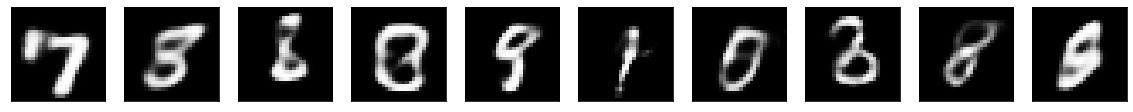

In [85]:
plt.figure(figsize=(2*n, 2))
for i in range(n):
  ax = plt.subplot(1, n, i + 1)
  plt.imshow(generated_images[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()